In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image

#tf.compat.v1.reset_default_graph()
#import tensorflow.datasets as tfds
%matplotlib inline

In [2]:
"""
ds = tfds.load('RockPaperScissors', split='train', as_supervised=True, shuffle_files=True)

ds = ds.shuffle(1000).batch(128)

@tf.function
def normalization(tensor):
    tensor = tf.image.resize(
    tensor, (128,128))
    tensor = tf.subtract(tf.divide(tensor, 127.5), 1)
    return tensor
"""

"\nds = tfds.load('RockPaperScissors', split='train', as_supervised=True, shuffle_files=True)\n\nds = ds.shuffle(1000).batch(128)\n\n@tf.function\ndef normalization(tensor):\n    tensor = tf.image.resize(\n    tensor, (128,128))\n    tensor = tf.subtract(tf.divide(tensor, 127.5), 1)\n    return tensor\n"

In [3]:
# label input
con_label = layers.Input(shape=(1,))

# latent vector input
latent_vector = layers.Input(shape=(100,))

In [4]:
def label_conditioned_generator(n_classes=3, embedding_dim=100):
    # embedding for categorical input
    label_embedding = layers.Embedding(n_classes, embedding_dim)(con_label)
    #print(label_embedding)
    # linear multiplication
    nodes = 4 * 4 
    label_dense = layers.Dense(nodes)(label_embedding)
    # reshape to additional channel
    label_reshape_layer = layers.Reshape((4, 4, 1))(label_dense)
    return label_reshape_layer

def latent_input(latent_dim=100):
    # image generator input
    nodes = 512 * 4 * 4
    latent_dense = layers.Dense(nodes)(latent_vector)
    latent_dense = layers.ReLU()(latent_dense)
    latent_reshape = layers.Reshape((4, 4, 512))(latent_dense)
    return latent_reshape

In [5]:
# define the final generator model
def define_generator():
    latent_vector_output = label_conditioned_generator()
    label_output = latent_input()
    # merge label_conditioned_generator and latent_input output
    merge = layers.Concatenate()([latent_vector_output, label_output])
    
    x = layers.Conv2DTranspose(64 * 8, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_1')(merge)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1')(x)
    x = layers.ReLU(name='relu_1')(x)
    
    x = layers.Conv2DTranspose(64 * 4, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_2')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2')(x)
    x = layers.ReLU(name='relu_2')(x)
    
    x = layers.Conv2DTranspose(64 * 2, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_3')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_3')(x)
    x = layers.ReLU(name='relu_3')(x)
  

    x = layers.Conv2DTranspose(64 * 1, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_4')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_4')(x)
    x = layers.ReLU(name='relu_4')(x) 
    
    
    out_layer = layers.Conv2DTranspose(3, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, activation='tanh', name='conv_transpose_6')(x)
    
    
   # define model
    model = keras.Model([con_label, latent_vector], out_layer)
    return model

In [6]:
model = define_generator()

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       300         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8192)         827392      input_2[0][0]                    
______________________________________________________________________________________________

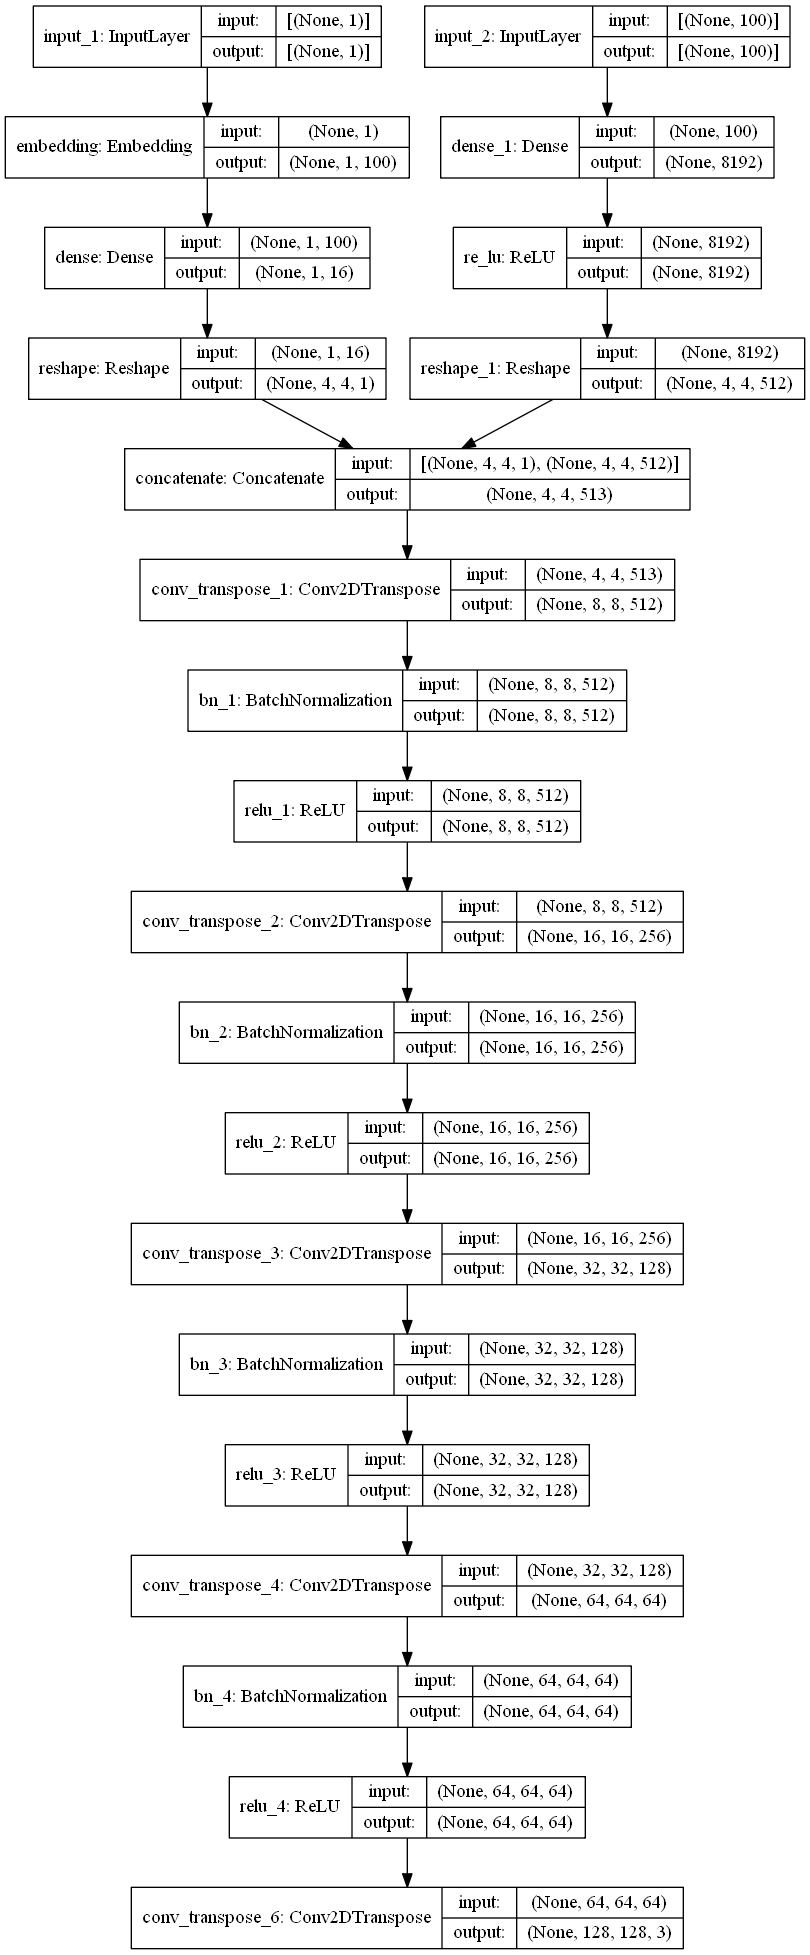

In [8]:

tf.keras.utils.plot_model(model, to_file='generator_Model.png', show_shapes=True)

Image('generator_Model.png')

In [9]:
# label input
con_label2 = layers.Input(shape=(1,))

# input image
inp_img = layers.Input(shape=(128,128,3))

In [10]:
def label_condition_disc(in_shape=(128,128,3), n_classes=3, embedding_dim=100):
    # label input
    #con_labeld = layers.Input(shape=(1,))
    # embedding for categorical input
    label_embedding2 = layers.Embedding(n_classes, embedding_dim)(con_label2)
    nodesd= in_shape[0] * in_shape[1] * in_shape[2]
    # scale up to image dimensions with linear layer
    label_densed = layers.Dense(nodesd)(label_embedding2)
    # reshape to a tensor
    label_reshape_layerd = layers.Reshape((in_shape[0], in_shape[1], 3))(label_densed)
    # image input
    return label_reshape_layerd


def image_disc(in_shape=(128,128,3)):
    inp_image = layers.Input(shape=in_shape)
    return inp_image

In [11]:
def define_discriminator():
    label_condition_output = label_condition_disc()
    inp_image_output = image_disc()
    # concat label as a channel
    merged = layers.Concatenate()([inp_image_output, label_condition_output])
    
    x = layers.Conv2D(64, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_1')(merged)
    x = layers.LeakyReLU(0.2, name='leaky_relu_1')(x)
    
    x = layers.Conv2D(64 * 2, kernel_size=4, strides= 3, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_2')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_2')(x)
    
    x = layers.Conv2D(64 * 4, 4, 3, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_3')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_3')(x)
      
    x = layers.Conv2D(64 * 8, 4, 3,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_5')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_4')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_5')(x)
  
 
    flattened_out = layers.Flatten()(x)
    # dropout
    dropout = layers.Dropout(0.4)(flattened_out)
    # output
    dense_out = layers.Dense(1, activation='sigmoid')(dropout)
    # define model


    # define model
    model = tf.keras.Model([inp_image_output, con_label2], dense_out)
    
    return model

In [12]:
model2 = define_discriminator()
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       300         input_3[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1, 49152)     4964352     embedding_1[0][0]                
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
____________________________________________________________________________________________

In [1]:
tf.keras.utils.plot_model(model2, to_file='Discriminator_Model.png', show_shapes=True)
Image('Discriminator_Model.png')

NameError: name 'tf' is not defined

In [13]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [14]:
def generator_loss(label, fake_output):
    gen_loss = binary_cross_entropy(label, fake_output)
    #print(gen_loss)
    return gen_loss

In [15]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,target):
    # noise vector sampled from normal distribution
    noise = tf.random.normal([target.shape[0], latent_dim])
    # Train Discriminator with real labels
    with tf.GradientTape() as disc_tape1:
        generated_images = conditional_gen([noise,target], training=True)

        
        real_output = conditional_discriminator([images,target], training=True)
        real_targets = tf.ones_like(real_output)
        disc_loss1 = discriminator_loss(real_targets, real_output)
        
    # gradient calculation for discriminator for real labels    
    gradients_of_disc1 = disc_tape1.gradient(disc_loss1, conditional_discriminator.trainable_variables)
    
    # parameters optimization for discriminator for real labels   
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc1,\
    conditional_discriminator.trainable_variables))
    
    # Train Discriminator with fake labels
    with tf.GradientTape() as disc_tape2:
        fake_output = conditional_discriminator([generated_images,target], training=True)
        fake_targets = tf.zeros_like(fake_output)
        disc_loss2 = discriminator_loss(fake_targets, fake_output)
    # gradient calculation for discriminator for fake labels 
    gradients_of_disc2 = disc_tape2.gradient(disc_loss2, conditional_discriminator.trainable_variables)
    
    
    # parameters optimization for discriminator for fake labels        
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc2,\
    conditional_discriminator.trainable_variables))
    
    # Train Generator with real labels
    with tf.GradientTape() as gen_tape:
        generated_images = conditional_gen([noise,target], training=True)
        fake_output = conditional_discriminator([generated_images,target], training=True)
        real_targets = tf.ones_like(fake_output)
        gen_loss = generator_loss(real_targets, fake_output)

    # gradient calculation for generator for real labels     
    gradients_of_gen = gen_tape.gradient(gen_loss, conditional_gen.trainable_variables)
    
    # parameters optimization for generator for real labels
    generator_optimizer.apply_gradients(zip(gradients_of_gen,\
    conditional_gen.trainable_variables))    